# Svensson (1994)



$$ r(t) = \beta_1 + \beta_2\frac{1-e^{-\lambda_1 t}}{\lambda_1 t} 
        + \beta_3 \left(\frac{1-e^{-\lambda_1 t}}{\lambda_1 t}-e^{-\lambda_1 t}\right)
        + \beta_4 \left(\frac{1-e^{-\lambda_2 t}}{\lambda_2 t}-e^{-\lambda_2 t}\right)$$

### Importing the data

In [84]:
from scipy.optimize import fmin
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from bizdays import Calendar
import os

path = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ"

df = pd.read_excel(os.path.join(path, "Titulos.xlsx"))
parameters = pd.read_excel(os.path.join(path, "Parametros.xlsx"))
selic = pd.read_excel(os.path.join(path, "SELIC.xlsx"))
ref_date_str = "2023-07-26"

#### Maturity and Coupon Calculation


In [85]:
### Selic treatments
cal = Calendar.load("ANBIMA")
parameters.set_index("Data referência", inplace=True)

In [58]:
### Selic treatments
cal = Calendar.load("ANBIMA")
parameters.set_index("Data referência", inplace=True)

selic.rename(columns={'Data': 'DATA_REFERENCIA'}, inplace=True)
selic.rename(columns={'CDI': 'EXPECTATIVA'}, inplace=True)
selic["CODIGO"]="SELIC"
selic["DATA_VENCIMENTO"]=cal.offset(selic["DATA_REFERENCIA"],1)
selic["PU"]=1000/((1+selic['EXPECTATIVA'])**(1/252))
selic = selic[["CODIGO",'DATA_REFERENCIA',"DATA_VENCIMENTO",'EXPECTATIVA',"PU"]]
df = pd.concat([df, selic], ignore_index=True)

In [86]:
### Maturity Calculation

df["Maturity"] = np.array(cal.bizdays(df["DATA_REFERENCIA"], df["DATA_VENCIMENTO"]))/252

### Coupon Calculation

df['Coupon'] = np.where(df['CODIGO'] == 'NTN-F', 10, 0)

# Function to generate the number of coupon days between two dates
def calculate_coupon_days(reference_date, maturity_date):
    first_january = pd.Timestamp(reference_date).replace(month=1, day=1)
    first_july = pd.Timestamp(reference_date).replace(month=7, day=1)
    
    coupon_dates = [first_january, first_july]
    
    next_january = first_january + pd.DateOffset(years=1)
    next_july = first_july + pd.DateOffset(years=1)
    
    while next_january <= maturity_date:
        coupon_dates.append(next_january)
        coupon_dates.append(next_july)
        next_january = next_january + pd.DateOffset(years=1)
        next_july = next_july + pd.DateOffset(years=1)
    
    coupon_days = [cal.bizdays(reference_date, coupon_date) for coupon_date in coupon_dates if coupon_date >= reference_date and coupon_date <= maturity_date]
    return coupon_days

# Função para calcular os cupons
def calculate_coupons(row):
    if row["CODIGO"] != "NTN-F":
        return np.zeros(0, dtype=int)  # Retorna um array vazio se não for "NTN-F"
    else:
        return np.array(calculate_coupon_days(row['DATA_REFERENCIA'], row['DATA_VENCIMENTO']), dtype=int)

# Duration

df["Coupons_days"] = df.apply(calculate_coupons, axis=1)

def sum_duration(row):
    return np.sum(row)

df['Duration'] = 1000 * ((1 + 0.1) ** (1 / 2) - 1) / ((1 + df['EXPECTATIVA'] / 100) ** (df['Coupons_days'] / 252)) * (df['Coupons_days'] / 252)
payment = 1000 / ((1 + df['EXPECTATIVA'] / 100) ** df['Maturity']) * df['Maturity']
df['Duration'] = (df['Duration'].apply(sum_duration) + payment) / df['PU']

df.set_index("DATA_REFERENCIA", inplace=True)

In [87]:
df.loc[ref_date_str]

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Maturity,Coupon,Coupons_days,Duration
DATA_REFERENCIA,,,,,,,,
2023-07-26,LTN,2023-10-01,13.1799,977.173313,0.182540,0,[],0.182629
2023-07-26,LTN,2024-01-01,12.6180,950.347347,0.424603,0,[],0.424803
2023-07-26,LTN,2024-04-01,12.0165,926.722634,0.670635,0,[],0.670635
2023-07-26,LTN,2024-07-01,11.4318,905.152465,0.920635,0,[],0.920635
2023-07-26,LTN,2024-10-01,10.9397,884.469473,1.182540,0,[],1.182540
2023-07-26,LTN,2025-01-01,10.5787,865.497011,1.432540,0,[],1.433111
2023-07-26,LTN,2025-04-01,10.4265,846.639208,1.678571,0,[],1.678571
2023-07-26,LTN,2025-07-01,10.2845,828.600532,1.920635,0,[],1.920635
2023-07-26,LTN,2025-10-01,10.2215,808.634163,2.182540,0,[],2.182540



### Generating individuals

In [103]:
N =1200             ### Number of individuals 
p = int(2/3*N)      ### Proportion of individuals generated by method 1
var = 0.25           ### variance normal distribution

### 1 - Initial Values of the results of the estimation of the previous day


ref_date = datetime.strptime(ref_date_str, "%Y-%m-%d")
previous_date = cal.offset(ref_date_str,-1)
previous_parameters = parameters.loc[str(previous_date)][1:]
beta_star_1 = np.array([previous_parameters.replace(previous_parameters[1],previous_parameters[0])])
e_previous = beta_star_1.T*np.random.normal(0, var, size=(6, p))
beta_previous = beta_star_1.T + e_previous

### 2 - Approximation that takes into account the observed yield to maturity (ytm)

data_estimada = df.loc[ref_date_str]
data_estimada=data_estimada.sort_values("Maturity")
diferencas_absolutas = (data_estimada['Duration'] - 1).abs()
b1 = data_estimada.iloc[np.argmin(diferencas_absolutas)]["EXPECTATIVA"]/100
b2 =  data_estimada.iloc[np.argmin(diferencas_absolutas)]["EXPECTATIVA"]/100 - data_estimada["EXPECTATIVA"][-1]/100
b3 = 0
b4 = 0
lbda1 = previous_parameters[4]
lbda2 = previous_parameters[5]
#lbda1 = (data_estimada["Maturity"][-1]-data_estimada["Maturity"][0])/2
#lbda2 = lbda1
beta_star_2 = np.array([b1, b2, b3 , b4, lbda1, lbda2])[:, np.newaxis]
e_approx = beta_star_2*np.random.normal(0, var, size=(6, N-p))
beta_approx = beta_star_2 + e_approx ## ajustar colunas

### Adding constraints to the parameters

def update (betas,beta_star):
    updated_value = []
    print(betas)
    for index, parameter in enumerate(betas):
        if parameter[0]<0:
            betas[index][0] = beta_star[0]+ beta_star[0]*np.random.normal(0, var)
            updated_value.append(betas[index][0]<0)
        if (parameter[0]+parameter[1])<0:
            betas[index][1] = beta_star[1]+ beta_star[1]*np.random.normal(0, var)
            updated_value.append((betas[index][0]+betas[index][1])<0)
        if parameter[4]<0 or parameter[4]>10:
            betas[index][4] = beta_star[4]+ beta_star[4]*np.random.normal(0, var)
            updated_value.append(betas[index][4]<0)
        if parameter[5]<0 or parameter[5]>10:
            betas[index][5] = beta_star[5]+ beta_star[5]*np.random.normal(0, var)
            updated_value.append(betas[index][5]<0)
    if sum(updated_value) != 0:
        update(betas,beta_star)
        
    return(betas)

update(beta_previous.T,beta_star_1.T)
update(beta_approx,beta_star_2)

individuals = np.concatenate((beta_previous.T, beta_approx.T), axis=0)

[[ 0.10031814  0.0790724   0.06214628 -0.06209891  2.08310217  1.27960516]
 [ 0.11756739  0.09613419  0.04231747 -0.10043297  3.0317233   1.29148428]
 [ 0.12558234  0.11049869  0.06207996 -0.07748329  2.81175482  1.79851396]
 ...
 [ 0.12543648  0.14482298  0.09559838 -0.11443497  2.5670806   0.92054282]
 [ 0.13505536  0.11826682  0.04916423 -0.13022944  2.0515315   1.50781434]
 [ 0.0934163   0.13225701  0.07808568 -0.10301324  4.36404721  1.94018265]]
[[1.44508374e-01 1.07461931e-01 9.98137789e-02 ... 9.50205608e-02
  1.35636390e-01 7.86899112e-02]
 [5.59909745e-03 6.62392673e-03 5.34011388e-03 ... 2.67309880e-03
  2.64085838e-03 6.51297102e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.44496052e+00 2.78346808e+00 2.28599577e+00 ... 3.26586832e+00
  3.22333650e+00 2.42251070e+00]
 [1.01507533e+00 1.70483937e+00 1.71724075e+00 ..

### Selection

In [104]:
df = data_estimada
alpha = 6
#var = 0.5
pi = 0.35
### 40% of the individuals survive
s = int(0.4 * N)
mty = df['Maturity']
cp_days = df["Coupons_days"]
price = df['PU']
duration = df["Duration"]

def minimization(c):
    nss = (c[0]) + (c[1] * ((1 - np.exp(-mty * c[4])) / (mty * c[4]))) + (c[2] * ((((1 - np.exp(-mty * c[4])) / (mty * c[4]))) - (np.exp(-mty * c[4])))) + (c[3] * ((((1 - np.exp(-mty * c[5])) / (mty * c[5]))) - (np.exp(-mty * c[5]))))    
    df["Calculated_Coupon"] = 1000 * ((1 + 0.1) ** (1 / 2) - 1) / (1 + nss) ** (cp_days/ 252)
    df["Calculated_Coupon"] = df["Calculated_Coupon"].apply(sum_duration)
    Calculated_price = 1000 / (1 + nss) ** mty + df["Calculated_Coupon"]
    df["Residual"] = ((price - Calculated_price) ** 2) * (1 / duration ** 0.5)
    
    val = np.sum(df['Residual'])
    return val

for interation in range(50):
    print(interation)
    
    values = []
    
    for row in individuals:    
        val = minimization(row)
        values.append((round(val,1), row))
        
    sol = pd.DataFrame(values, columns=['SC', "Parameters"])
    

    selection = sol.sort_values('SC')[0:s]
    new_individuals = []
    
    if interation > 1:
        var = var*1.02
        
    ### Cross-Over
    
    psi = np.random.uniform(0, 1,N)
    selected_rows = selection.iloc[(np.random.beta(1, alpha, N) * s)]
    selected_rows.reset_index(drop=True, inplace=True)
    theta_r = selected_rows["Parameters"]
    theta_s = selected_rows["Parameters"]
         
    next_gen = psi * theta_r + (1 - psi) * theta_s
       
        
    ### Mutation
    e = np.random.choice([0, 1], size=(6, N), p=[1 - pi, pi])*np.random.normal(0, var, size=(6, N))
    next_gen_list = next_gen.tolist()
    next_gen_array = np.array(next_gen_list)
    update(next_gen_array,beta_star_1.T)
    new_individuals = next_gen_array * e.T+next_gen_array
         
    individuals = new_individuals
    
        
selection.head()



0
[[0.10522055 0.00586563 0.         0.         1.32572952 1.3984174 ]
 [0.10114416 0.00326953 0.         0.         1.50425823 0.96847763]
 [0.10584454 0.00550631 0.         0.         3.00103813 1.2654762 ]
 ...
 [0.10494794 0.00598602 0.         0.         2.15794242 1.29314805]
 [0.10961499 0.00534443 0.         0.         2.96526521 0.60726184]
 [0.10273662 0.0064646  0.         0.         3.07691753 1.34074576]]
1
[[0.10620325 0.00954508 0.         0.         3.71254729 1.53356867]
 [0.10494794 0.00598602 0.         0.         2.15794242 1.29314805]
 [0.10719959 0.00414301 0.         0.         3.0671309  1.11550355]
 ...
 [0.10591638 0.00684376 0.         0.         3.5349647  1.28545171]
 [0.10584454 0.00477653 0.         0.         3.00103813 1.2654762 ]
 [0.10538834 0.00417774 0.         0.         0.96692442 0.79153371]]
2
[[ 0.10591638  0.01131203  0.          0.          4.71895066  1.81735666]
 [ 0.10591638  0.00923177  0.          0.          5.50166384  0.73929142]
 [ 0

[[ 0.11204893  0.0264998   0.06343885 -0.09165632  2.66028477  1.27146382]
 [ 0.11204893  0.02176053  0.06403282 -0.09059071  2.96816522  1.32869703]
 [ 0.11113725  0.02645505  0.06392203 -0.08081874  3.07622066  1.33854521]
 ...
 [ 0.11055212  0.02794771  0.07991035 -0.09858138  2.86679117  1.57317762]
 [ 0.11204893  0.02913359  0.0565958  -0.0956572   2.24468067  1.28333892]
 [ 0.11204893  0.03212504  0.05784147 -0.09681434  2.17834885  1.28333892]]
20
[[ 0.11204893  0.02617771  0.06403282 -0.09165632  2.78663373  1.38267509]
 [ 0.11204893  0.02614886  0.06403282 -0.09165632  2.61965442  1.27417974]
 [ 0.11177792  0.02315473  0.07924653 -0.08664137  3.47233261  1.43646022]
 ...
 [ 0.11204893  0.02614886  0.06403282 -0.09059071  2.75781282  1.32869703]
 [ 0.11204893  0.02614886  0.06403282 -0.09059071  2.75781282  1.32869703]
 [ 0.11204893  0.03933772  0.04964432 -0.09165632  2.66028477  1.35238754]]
21
[[ 0.11204893  0.01855627  0.065468   -0.09383932  2.54538407  1.3521636 ]
 [ 0.11

[[ 0.11204893  0.02453053  0.06674352 -0.09383932  2.60122763  1.31488514]
 [ 0.11204893  0.02407763  0.06794481 -0.09064994  2.70819895  1.32869703]
 [ 0.11204893  0.02366233  0.06343885 -0.09064994  2.70819895  1.32869703]
 ...
 [ 0.11204893  0.03290449  0.06343885 -0.09064994  2.70819895  1.32869703]
 [ 0.11204893  0.02611347  0.06585494 -0.09351821  2.64473034  1.32869703]
 [ 0.11204893  0.02893762  0.06333312 -0.09383932  2.6743526   1.3521636 ]]
38
[[ 0.11204893  0.02609113  0.06343885 -0.09064994  2.70819895  1.32869703]
 [ 0.11204893  0.02753639  0.06333312 -0.09383932  2.6743526   1.3521636 ]
 [ 0.11204893  0.02214399  0.06781263 -0.09100112  2.62682542  1.3521636 ]
 ...
 [ 0.11204893  0.02639538  0.06433416 -0.09064994  2.70819895  1.32869703]
 [ 0.11204893  0.02222459  0.06781263 -0.09383932  2.66028477  1.3521636 ]
 [ 0.11204893  0.02769979  0.06333312 -0.09383932  2.6743526   1.40637115]]
39
[[ 0.11204893  0.02514056  0.06945762 -0.09383932  2.72645047  1.3521636 ]
 [ 0.11

,SC,Parameters
900,4.8,"[0.11204892883792117, 0.025140562967887935, 0...."
996,4.8,"[0.11204892883792117, 0.025140562967887935, 0...."
641,4.8,"[0.11204892883792117, 0.025140562967887935, 0...."
915,4.8,"[0.11204892883792117, 0.025140562967887935, 0...."
589,4.8,"[0.11204892883792117, 0.025140562967887935, 0...."


In [105]:
dia26 = selection.iloc[0]["Parameters"]
dia26_anbima = parameters.iloc[-2,1:].values
print(dia26)
print(dia26_anbima)

[ 0.11204893  0.02514056  0.06828713 -0.09339351  2.72645047  1.3521636 ]
[0.114358254774121 0.018715794279205 0.0679754297455865
 -0.0961284649369684 2.70022735771407 1.22958147196742]


Text(0.5, 1.0, '2023-07-26 00:00:00')

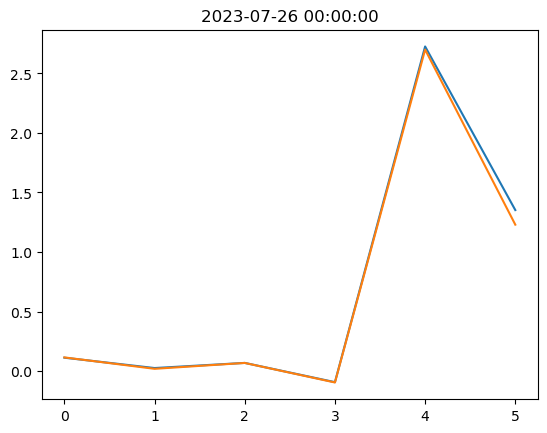

In [106]:
rounded_series = selection["Parameters"].apply(lambda lst: [round(x, 1) for x in lst])
rounded_series[0:99]
plt.plot(dia26)
plt.plot(dia26_anbima)
plt.title(f'{ref_date}')

In [ ]:
var

In [92]:
df

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Maturity,Coupon,Coupons_days,Duration,Calculated_Coupon,Residual
DATA_REFERENCIA,,,,,,,,,,
2023-07-26,LTN,2023-10-01,13.1799,977.173313,0.182540,0,[],0.182629,0.000000,7.063656
2023-07-26,LTN,2024-01-01,12.6180,950.347347,0.424603,0,[],0.424803,0.000000,14.908641
2023-07-26,LTN,2024-04-01,12.0165,926.722634,0.670635,0,[],0.670635,0.000000,26.967518
2023-07-26,LTN,2024-07-01,11.4318,905.152465,0.920635,0,[],0.920635,0.000000,43.459279
2023-07-26,LTN,2024-10-01,10.9397,884.469473,1.182540,0,[],1.182540,0.000000,69.184661
2023-07-26,LTN,2025-01-01,10.5787,865.497011,1.432540,0,[],1.433111,0.000000,94.715811
2023-07-26,NTN-F,2025-01-01,10.6749,997.797890,1.432540,10,"[107, 232, 361]",1.363056,132.445350,94.501856
2023-07-26,LTN,2025-04-01,10.4265,846.639208,1.678571,0,[],1.678571,0.000000,108.402175
2023-07-26,LTN,2025-07-01,10.2845,828.600532,1.920635,0,[],1.920635,0.000000,125.302456


In [ ]:
Calculated_price